In this notebook we will explore different predictors to predict the outcome of match for *Heroes of the Storm* (HOTS) from *Blizzard*. The data used for this analysis was downloaded from [hotslog.com](https://d1i1jxrdh2kvwy.cloudfront.net/Data/HOTSLogs%20Data%202015-12-30%20-%202016-01-29.zip) database. This data set includes around 2 millions games played during December 2015. 

I hope to reach some conclusions about what we need to make a good predictor. 

In [15]:
#Simple getting the data and setting the data sets
%matplotlib inline
import pandas as pd
import seaborn as sns 
import numpy as np
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
df = pd.read_csv('data/learning_ready_with_mmr.csv')
df = df.iloc[1000000:1500000] #keep some data, I used the first million entries to train de predictors
#With 10-fold the variance is very low, e.g. < 0.1 for each predictor, thus I decided 
#to test on a different dataset and only show that agreagated result. 

#Create the dataset we want to test our predictors on
dfOneTeam = pd.concat([df.iloc[:,1:49], df.iloc[:,-1]],axis=1)
dfTwoTeams = pd.concat([df.iloc[:,1:97],df.iloc[:,-1]],axis=1)
dfTwoTeamsMMR = df.iloc[:,1:108]
dfMMR = df.iloc[:,97:108]
#load the different predictors
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

clfOneTeam = joblib.load('OneTeam/clf.pkl') 
clfTwoTeams = joblib.load('TwoTeams/clf.pkl')
clfTwoTeamsMMR = joblib.load('TwoTeamsMMR/clf.pkl')
clfMMR = joblib.load('MMR/clf.pkl')

Offline this file (you can consult the different scripts in this github repo), I have trained different random tree classifiers using sklearn based on different criteria. HOTS is a 5 *vs.* 5 game, where each player selects a hero out of 50 choices. Within the same team it is impossible to pick the same hero. We will denote a team selection of heros a composition. 

We first investigate our capacity to predict the winning team if we only know one team composition. 

In [20]:
results = {}
results['OneTeam'] = clfOneTeam.score(dfOneTeam.iloc[:,:-1],dfOneTeam.iloc[:,-1])
results['OneTeam']

0.663968

Given one team composition we can predict 66% of the time if the team is a winning one. From the k-fold validation I did in the .py files, the variance is around 0.1%. This is already a lot better than simply flipping a coin between the two teams. This actually suggests that the team composition is import for winning. 

Lets investigate the same prediction but if are given the composition of both teams. 

In [21]:
results['TwoTeams'] = clfTwoTeams.score(dfTwoTeams.iloc[:,:-1],dfTwoTeams.iloc[:,-1])
results['TwoTeams']

0.72867999999999999

We are doing even better if we know both teams composition. This suggests that the composition is very imortant to winning a fight. 

In HOTS, and most competitive games, the players are ranked againts each others. Most modelled are inspired by the famous ELO rating for professionnal chess rating. HOTSlogs uses a Match Making Ratio (MMR) and provided the dataset with such information. In general the higher your number is, the greater a player you are. Thus, if a team has a higher MMR than the other team, then that team should win the fight. 

We next investigate if only using the teams MMRs we can predict the winning one.  

In [22]:
results['MMR'] = clfMMR.score(dfMMR.iloc[:,:-1],dfMMR.iloc[:,-1])
results['MMR']

0.51815

This result does not suggests that the MMR is useless. I believe this means the fights that occurs on HOTS matching algorithm are actually strongly based on MMR. This resluts proposed that most team MMR are similar when they enter a fight and the output is unknown. 

In order to evaluate that last argument more, lets add the teams MMR to the data and see if we can predict the output better. 

In [23]:
results['TwoTeamsMMR'] = clfTwoTeamsMMR.score(dfTwoTeamsMMR.iloc[:,:-1],dfMMR.iloc[:,-1])
results['TwoTeamsMMR']

0.71156799999999998

This result solidifies the last argument, the matching algorithm uses mainly MMR to match teams. The real difference is in the team composition. Here lets have a look at all the predictors approaches in one graph. 

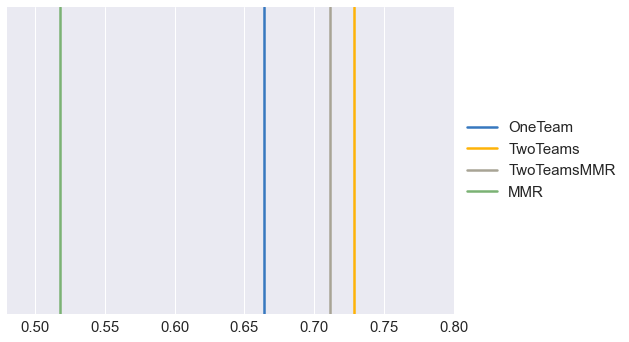

In [41]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
j = 0 
for i in results:
    ax = sns.plt.axvline(results[i],label=i,color = sns.xkcd_rgb[colors[j]])
    j+=1
sns.plt.xlim([0.48,0.8])
sns.plt.yticks([],[])
sns.plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In general in this notebook, we investigate how a team composition can influence the outcome of a match. We also discover some details about the matchmaking algo

The next step for this work would to obviously explore different classifier to see if we could improved on our results. Deep neural networks might be an interesting approach and will probably show interesting structure in the hero selections. 

